# **Tarea 2**

Se definen las librerias requeridas

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
from IPython.display import display

## _Punto 1:_

### Modelado del problema como un MDP

Modele este problema como un MDP. Detalle todos los elementos del MDP:

- **Estados**  
- **Recompensas**  
- **Acciones**  
- **Dinámica de transición**:  
  $$ p(s', r \mid s, a) \quad \forall s, s', r, a $$  
- **Factor de descuento**:  
  $$ \gamma $$

Se definen las razones de probabilidad del dado cargado, lo que significa que las probailidades no son uniformes, algunas tienen más probabilidad de salir que otras. En lugar de un dado justo con una probabilidad uniforme de 1/6, aquí se asignan valores específicos: sacar un 1 o 6 tiene una probabilidad de 10%, un 2 o un 5 ocurre el 15% del tiempo, y un 3 o un 4 sucede con mayor frecuencia (20%). Esto afecta las transiciones del MDP, ya que los valores medios (3 y 4) serán más comunes, influyendo en la estrategia óptima del jugador al moverse en el tablero.

In [17]:
probabilidades = np.array([0.1, 0.2, 0.3, 0.2, 0.1, 0.1])  # dado cargado

A continuación, se definen dos diccionarios en Python que modelan las escaleras y serpientes del tablero, donde las claves representan las casillas de inicio y los valores indican las casillas destino. El diccionario escaleras indica las casillas donde un jugador avanza automáticamente a una posición más alta, mientras que serpientes representa las casillas que obligan al jugador a retroceder, dificultando su progreso. Estas transiciones no lineales afectan la dinámica del juego y se incorporan en la función de probabilidad de transición del MDP, asegurando que el modelo refleje correctamente las reglas del juego.

In [18]:
# Definir posiciones de escaleras y serpientes
escaleras = {8: 26, 21: 82, 43: 77, 50: 91, 54: 93, 66: 87, 62: 96} # modelado de 7 escaleras, la escalera que conecta los estados 80 y 100, por practicidad no se considera al ser ambos estados terminales de victoria.
serpientes = {52: 11, 69: 33, 92: 51, 48: 9, 73: 1, 55: 7, 46: 5, 95: 24, 64: 36, 44: 22, 98: 28, 83: 19, 59: 17} # modelado de serpientes

Se define la constante gamma dada por el ejercicio

In [19]:
gamma = 0.9

Se definen mediante listas, los estados correspondientes a victoria o derrota denotados en la grafica de color azul y rojo respectivamente, así como los estados terminales en conjunto.

In [7]:
# Estados especiales
estadoGanar = [80, 100]
estadoPerder = [23, 37, 45, 67, 89]
estadosTerminales = set(estadoGanar + estadoPerder)
estadosInvalidos = set(escaleras.keys()).union(set(serpientes.keys()))
estadosValidos = set(range(1, 101)) - estadosTerminales - estadosInvalidos

Se inicializa la tabla de valor de estado, poniendo los valores en 0, y se inicializan las recompensas, como se establece en el tablero del ejercicio

In [8]:
# Inicialización de estados y recompensas
valoresEstado = {s: 0 for s in range(1, 101)}
recompensasEstado = {s: (100 if s in estadoGanar else -100 if s in estadoPerder else -1) for s in range(1, 101)}
acciones = ["avanzar", "retroceder"]

Se muestra la matriz inicial con los valores de estado inicializados

In [9]:
def mostrarMatrizInicial():
    matriz = np.zeros((10, 10), dtype=object)
    for i in range(10):
        for j in range(10):
            estado = i * 10 + (j + 1 if i % 2 == 0 else 10 - j)
            matriz[9 - i, j] = f"{valoresEstado[estado]:7.2f}"
    print("\nMatriz Inicial de Valores de Estado (10x10):")
    for fila in matriz:
        print(" ".join(str(valor) for valor in fila))

mostrarMatrizInicial()


Matriz Inicial de Valores de Estado (10x10):
   0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00
   0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00
   0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00
   0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00
   0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00
   0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00
   0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00
   0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00
   0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00
   0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00


Se muestra la distribución de recompensas esstablecida para el ejercicio

In [10]:
def mostrarMatrizRecompensas():
    matriz = np.zeros((10, 10), dtype=object)
    for i in range(10):
        for j in range(10):
            estado = i * 10 + (j + 1 if i % 2 == 0 else 10 - j)
            matriz[9 - i, j] = f"{recompensasEstado[estado]:7d}"
    print("\nMatriz de Recompensas por Estado (10x10):")
    for fila in matriz:
        print(" ".join(str(valor) for valor in fila))

mostrarMatrizRecompensas()


Matriz de Recompensas por Estado (10x10):
    100      -1      -1      -1      -1      -1      -1      -1      -1      -1
     -1      -1      -1      -1      -1      -1      -1      -1    -100      -1
    100      -1      -1      -1      -1      -1      -1      -1      -1      -1
     -1      -1      -1      -1      -1      -1    -100      -1      -1      -1
     -1      -1      -1      -1      -1      -1      -1      -1      -1      -1
     -1      -1      -1      -1    -100      -1      -1      -1      -1      -1
     -1      -1      -1    -100      -1      -1      -1      -1      -1      -1
     -1      -1    -100      -1      -1      -1      -1      -1      -1      -1
     -1      -1      -1      -1      -1      -1      -1      -1      -1      -1
     -1      -1      -1      -1      -1      -1      -1      -1      -1      -1


Se define una función para graficar las recompensas

In [11]:
def mostrarGraficoRecompensas(recompensas):
    plt.plot(recompensas)
    plt.xlabel("Episodio")
    plt.ylabel("Recompensa Acumulada")
    plt.title("Recompensas Acumuladas por Episodio")
    plt.grid(True)
    plt.show()

Esta función, calcula el próximo estado en el juego de escaleras y serpientes considerando la acción elegida (avanzar o retroceder) y el resultado del dado. Si el estado actual es terminal, retorna el mismo estado. Luego, según la acción, suma o resta el valor del dado. Aplica una lógica de rebote cuando el estado excede los límites del tablero (mayor a 100 o menor a 1), aunque el rebote en el extremo inferior podría mejorarse para mayor precisión. Finalmente, si el nuevo estado corresponde a la base de una escalera o la cabeza de una serpiente, se actualiza automáticamente al estado resultante. La función es sólida, pero convendría revisar y ajustar la lógica del rebote en el extremo inferior para mayor exactitud.

In [12]:
def calcularNuevoEstado(s, a, resultadoDado):
    if s in estadosTerminales:
        return s

    if a == "avanzar":
        nuevoEstado = s + resultadoDado
    elif a == "retroceder":
        nuevoEstado = s - resultadoDado
    else:
        raise ValueError("Acción no válida")

    if nuevoEstado < 1:
        nuevoEstado = abs(nuevoEstado) + 1
    elif nuevoEstado > 100:
        if s == 99 and resultadoDado in [1, 2]:
            nuevoEstado = 100
        else:
            exceso = nuevoEstado - 100
            nuevoEstado = 100 - exceso

    if nuevoEstado in escaleras:
        nuevoEstado = escaleras[nuevoEstado]
    if nuevoEstado in serpientes:
        nuevoEstado = serpientes[nuevoEstado]

    return nuevoEstado

Se define una función que ejecuta 1000 simulaciones del juego, comenzando cada episodio en la casilla 1 y finalizando al llegar a un estado terminal. En cada paso, el agente elige aleatoriamente avanzar o retroceder, lanza un dado cargado para determinar el número de casillas a mover y calcula el nuevo estado considerando las reglas del juego (incluyendo escaleras, serpientes y rebotes). Luego, aplica la ecuación de Bellman en tiempo real para actualizar el valor del estado actual, ponderando las probabilidades del dado y considerando la recompensa obtenida más el valor futuro esperado con un factor de descuento de 0.9. La actualización es una media entre el valor calculado y el valor anterior del estado. La recompensa acumulada de cada episodio se registra en una lista, la cual se retorna al finalizar las simulaciones.

In [13]:
def bellmanDP():
    recompensasAcumuladas = []
    for _ in range(1000):
        estado = 1
        recompensaAcumulada = 0
        while estado not in estadosTerminales:
            accion = np.random.choice(acciones)
            resultadoDado = np.random.choice([1, 2, 3, 4, 5, 6], p=probabilidades)
            nuevoEstado = calcularNuevoEstado(estado, accion, resultadoDado)
            recompensa = recompensasEstado[nuevoEstado]

            # Ecuación de Bellman
            nuevoValor = 0
            for accionSimulada in acciones:
                for dado, p in zip(range(1, 7), probabilidades):
                    siguienteEstado = calcularNuevoEstado(estado, accionSimulada, dado)
                    r = recompensasEstado[siguienteEstado]
                    nuevoValor += (1 / len(acciones)) * p * (r + gamma * valoresEstado[siguienteEstado])

            valoresEstado[estado] = nuevoValor
            recompensaAcumulada += recompensa
            estado = nuevoEstado

        recompensasAcumuladas.append(recompensaAcumulada)
    return recompensasAcumuladas

Se define una función, que visualiza los valores finales de cada estado del tablero en formato de matriz 10x10, reflejando la disposición del juego de escaleras y serpientes. Primero, inicializa una matriz de 10x10 con ceros y tipo de dato object para formatear los valores como texto. Luego, recorre cada celda utilizando dos bucles anidados: el índice i determina la fila y j la columna. Para reflejar el patrón en zigzag del tablero (donde las filas pares avanzan de izquierda a derecha y las impares de derecha a izquierda), se usa la condición i % 2 para calcular el número del estado correspondiente. El valor del estado se asigna a la celda correspondiente con formato de dos decimales. Finalmente, la función imprime la matriz, mostrando cada fila con los valores alineados, lo que proporciona una visualización clara de los valores finales de cada casilla del tablero.

In [14]:
def mostrarMatrizValores():
    matriz = np.zeros((10, 10), dtype=object)
    for i in range(10):
        for j in range(10):
            estado = i * 10 + (j + 1 if i % 2 == 0 else 10 - j)
            matriz[9 - i, j] = f"{valoresEstado[estado]:7.2f}"
    print("\nMatriz de Valores Finales de los Estados (10x10):")
    for fila in matriz:
        print(" ".join(str(valor) for valor in fila))

Se ejecuta la simulación parametrizada y generar los datos tabulares.

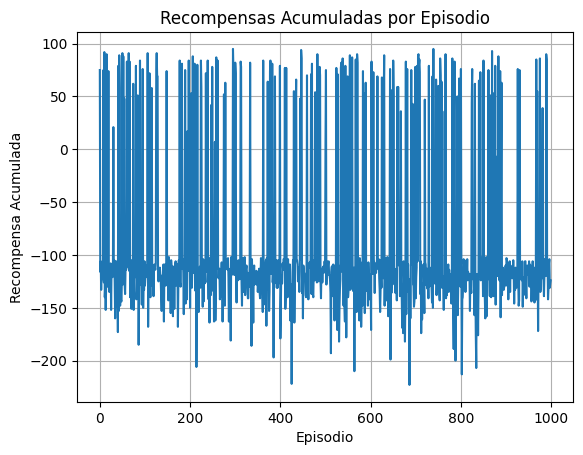


Matriz de Valores Finales de los Estados (10x10):
   0.00   -1.76    0.00   -1.00   -8.91    0.00  -18.53  -27.96    0.00  -29.77
  -3.52   -0.15    0.00   -8.12  -19.16  -25.47  -27.90  -25.31    0.00  -26.75
   0.00   -1.69    3.29    6.30    0.31   -6.87   -8.56    0.00  -22.83  -28.01
 -23.56    0.00  -31.57    0.00  -33.06    0.00    0.00  -31.13    0.00  -34.07
 -21.28    0.00    0.00  -14.98  -20.51    0.00    0.00  -22.72    0.00  -28.19
 -45.57  -46.54    0.00    0.00    0.00    0.00  -32.58    0.00  -30.69    0.00
 -44.65  -45.66  -42.43    0.00  -44.57  -46.74  -49.17  -46.22  -43.65  -43.70
   0.00  -34.72    0.00  -34.06  -39.28  -44.46  -41.73  -41.43  -42.75  -40.26
 -38.11  -32.35  -27.04  -28.30  -25.57  -24.49  -26.20  -25.27  -25.54  -26.34
 -22.60  -23.49  -23.35  -24.20  -25.27  -24.61  -24.09    0.00  -24.42  -25.30


In [15]:
# Ejecutar simulación con Bellman
recompensas = bellmanDP()
mostrarGraficoRecompensas(recompensas)
mostrarMatrizValores()

### Consideraciones del MDP

- La meta del jugador es ganar la partida llegando a una de las casillas marcadas en azul
- El jugardor pierde la partida si cae en una de las casillas marcadas en rojo
- En cada jugada, **antes de lanzar el dado**, el jugador dedice si quiere avanzar o retroceder el número de casillas indicadas por lado
- El dado está cargado con probalidades **p =[p1,p2,p3,p4,p5,p6]**
- En las casillas 1 y 100 la ficha rebota (si se supera el extremo, se avanza en la otra dirección la cantidad restante)

## _Punto 2:_

### Modelado del problema como un MDP

Modele este problema como un MDP. Detalle todos los elementos del MDP:

- **Estados**  
- **Recompensas**  
- **Acciones**  
- **Dinámica de transición**:  
  $$ p(s', r \mid s, a) \quad \forall s, s', r, a $$  
- **Factor de descuento**

Con los datos suministrados en el enunciado, se puede colocar podemos definir las variables con las que vamos a trabajar a lo largo del problema. Con estas varibales podemos definir una función que tenga como objetivo modelar el MDP, dando como resultado la transciones y las recompensas asociadas a estas.

In [60]:
# informacion inicial que se suministra en el enunciado
tamañoTablero = 100
gana = {80,100} #el usuario ingresa las celdas azules
pierde = {23, 37, 45, 67, 89} #el usuario ingresa la celdas rojas
acciones = [-1,1]
probabilidades = np.ones(6)/6 #se tiene un dado con probabilidades uniformes
estados = np.arange(1, tamañoTablero+1) # se configura de esta manera para que vaya desde el 1 al 100

Para verificar los estados del ejercicio,se implementa un dataframe que indica para cada estado del tablero (1 al 100) si es una casilla de victoria o de derrota, usando las columnas "Es Terminal Ganar" y "Es Terminal Perder" para marcar con 1 los estados especiales y con 0 el resto.

In [61]:
# Crear un DataFrame con la información del tablero
dfEstados = pd.DataFrame({
    'Estado': estados,
    'Es Terminal Ganar': [1 if s in gana else 0 for s in estados],
    'Es Terminal Perder': [1 if s in pierde else 0 for s in estados]
})

display(dfEstados)

,Estado,Es Terminal Ganar,Es Terminal Perder
0,1,0,0
1,2,0,0
2,3,0,0
3,4,0,0
4,5,0,0
...,...,...,...
95,96,0,0
96,97,0,0
97,98,0,0
98,99,0,0


Se define una función para estructurar la dinámica del juego como un MDP, generando para cada estado y acción posibles las transiciones a nuevos estados (considerando rebotes, escaleras y serpientes) y sus recompensas. Retorna dos diccionarios: uno con las probabilidades de transición (transicion) y otro con las recompensas esperadas (recompensas).

In [86]:
def construirMDP(probabilidades, estados):
    transicion = {}
    recompensas = {}

    for s in estados:
        for a in acciones:
            transicion[(s, a)] = []
            recompensas[(s, a)] = []

            for resultadoDado, probabilidad in zip(range(1, 7), probabilidades):
                nuevoEstado = s + a * resultadoDado

                # Lógica de rebote validada
                if nuevoEstado < 1:
                    nuevoEstado = abs(nuevoEstado) + 1
                elif nuevoEstado > 100:
                    if s == 99 and resultadoDado in [1, 2]:
                        nuevoEstado = 100
                    else:
                        exceso = nuevoEstado - 100
                        nuevoEstado = 100 - exceso

                # Aplicar efecto de serpientes y escaleras
                if nuevoEstado in serpientes:
                    nuevoEstado = serpientes[nuevoEstado]
                elif nuevoEstado in escaleras:
                    nuevoEstado = escaleras[nuevoEstado]

                # Asignar recompensa según el tipo de casilla
                if nuevoEstado in pierde:
                    recompensa = -100
                elif nuevoEstado in gana:
                    recompensa = 100
                else:
                    recompensa = -1

                # Guardar transiciones y recompensas
                transicion[(s, a)].append((nuevoEstado, probabilidad))
                recompensas[(s, a)].append((probabilidad, recompensa))

    return transicion, recompensas

Se define una función que aplica el algoritmo de iteración de valor para calcular la política y los valores óptimos de un MDP. Evalúa cada estado no terminal, calcula el valor esperado de cada acción con la ecuación de Bellman y actualiza el valor del estado con el mejor resultado. Repite este proceso hasta que los cambios sean mínimos, devolviendo la política óptima pi, los valores V y el último delta.

In [87]:
def interacionValor(gana, pierde, transicion, recompensas, estados, acciones, tamaño_tablero, gamma, error=1e-2):
    V = np.zeros(tamaño_tablero + 1)
    pi = np.zeros(tamaño_tablero + 1)

    for s in gana:
        V[s] = 100
    for s in pierde:
        V[s] = -100

    delta = 100
    while delta >= error:
        delta = 0
        for s in estados:
            if s in gana or s in pierde:
                continue

            mejorV = -np.inf
            mejorAccion = None

            for a in acciones:
                valor = 0
                for (nuevoEstado, probabilidad), (probabilidad_r, recompensa) in zip(transicion[(s, a)], recompensas[(s, a)]):
                    contribucion = probabilidad * (recompensa + gamma * V[nuevoEstado])
                    valor += contribucion

                if valor > mejorV:
                    mejorV = valor
                    mejorAccion = a

            delta = max(delta, abs(V[s] - mejorV))
            V[s] = mejorV
            pi[s] = mejorAccion

    # Construir el DataFrame con los resultados
    data = []
    for s in estados:
        if s not in gana and s not in pierde:
            data.append({
                'Estado': s,
                'Valor de Estado': V[s],
                'Mejor Acción': pi[s]
            })
    dfValoresPolitica = pd.DataFrame(data)

    return dfValoresPolitica, pi, V, delta

Se ejecuta la función que define el modelo del MDP, devolviendo dos diccionarios: transicion, que contiene las posibles transiciones y sus probabilidades para cada par (estado, acción), y recompensas, que asigna recompensas esperadas para esas transiciones, considerando escaleras, serpientes, rebotes y las reglas del juego.

In [88]:
transicion, recompensas = construirMDP(probabilidades, estados)

Se realiza una verificación para evidenciar el contenido del diccionario transicion, el cual almacena todas las posibles transiciones del modelo MDP. Específicamente, para cada par (estado, acción), contiene una lista de tuplas con los posibles estados siguientes y la probabilidad asociada de llegar a ellos, modelando así la dinámica estocástica del entorno.

In [89]:
filas = []
for (estado, accion), transiciones in transicion.items():
    for s_, p in transiciones:
        filas.append({'Estado': estado, 'Acción': accion, 'Siguiente Estado': s_, 'Probabilidad': p})

dfTransiciones = pd.DataFrame(filas)
display(dfTransiciones.head(10))  # Visualiza las primeras 10 filas

,Estado,Acción,Siguiente Estado,Probabilidad
0,1,-1,1,0.166667
1,1,-1,2,0.166667
2,1,-1,3,0.166667
3,1,-1,4,0.166667
4,1,-1,5,0.166667
5,1,-1,6,0.166667
6,1,1,2,0.166667
7,1,1,3,0.166667
8,1,1,4,0.166667
9,1,1,5,0.166667


Se realiza una transforma del diccionario recompensas, en un DataFrame de pandas para visualizarlo en forma tabular; recorre cada (estado, acción) y extrae sus pares (probabilidad, recompensa) en una lista de diccionarios, que luego se convierte en una tabla con columnas 'Estado', 'Acción', 'Probabilidad' y 'Recompensa'.

In [90]:
# Convertir el diccionario recompensas a una lista de filas
filas = []
for (estado, accion), lista in recompensas.items():
    for probabilidad, recompensa in lista:
        filas.append({
            'Estado': estado,
            'Acción': accion,
            'Probabilidad': probabilidad,
            'Recompensa': recompensa
        })

# Crear el DataFrame
dfRecompensas = pd.DataFrame(filas)

# Mostrar tabla
display(dfRecompensas)

,Estado,Acción,Probabilidad,Recompensa
0,1,-1,0.166667,-1
1,1,-1,0.166667,-1
2,1,-1,0.166667,-1
3,1,-1,0.166667,-1
4,1,-1,0.166667,-1
...,...,...,...,...
1195,100,1,0.166667,-1
1196,100,1,0.166667,-1
1197,100,1,0.166667,-1
1198,100,1,0.166667,-1


Se ejecuta el algoritmo de iteración de valor para obtener la política óptima pi, los valores de estado V y el cambio máximo delta, usando las dinámicas y recompensas del MDP, junto con el factor de descuento y un criterio de convergencia.

In [91]:
dfValoresPolitica, pi, V, delta = interacionValor(gana, pierde, transicion, recompensas, estados, acciones, tamañoTablero, gamma, error=1e-3)
display(dfValoresPolitica)

,Estado,Valor de Estado,Mejor Acción
0,1,8.575766,1.0
1,2,7.090523,-1.0
2,3,8.162275,1.0
3,4,9.978129,1.0
4,5,11.557142,1.0
...,...,...,...
88,95,71.994298,1.0
89,96,61.562426,1.0
90,97,61.562426,1.0
91,98,71.994356,1.0


Se realiza una verificación del delta, para permitir verificar si el algoritmo de iteración de valor ha convergido, ya que representa el mayor cambio entre valores de estado en una iteración; el proceso se detiene cuando delta es menor al umbral definido.

In [92]:
delta

0.0007875959727154935

Ahora, se muestran los valores estimados de los estados del 1 al 99, omitiendo el estado 0 por no ser parte del tablero.

In [93]:
# Convertir V[1:101] a una matriz 10x10 con el orden tipo serpenteo (zigzag)
valoresTablero = V[1:101].reshape(10, 10)

valoresTablero = np.flipud(valoresTablero)

for i in range(10):
    if i % 2 == 1:
        valoresTablero[i] = valoresTablero[i][::-1]

dfValores = pd.DataFrame(valoresTablero, columns=[f"C{j+1}" for j in range(10)], index=[f"F{10-i}" for i in range(10)])
display(dfValores)

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10
F10,34.784902,30.458714,36.872752,59.744447,71.994298,61.562426,61.562426,71.994356,79.632921,100.000000
F9,31.550440,-100.000000,71.282891,75.560985,93.386364,93.386354,93.386343,104.081642,104.081628,104.081613
F8,72.401673,75.138808,87.860362,104.081495,104.081514,104.081533,93.386259,93.386273,93.386286,100.000000
F7,69.253967,64.029806,47.220091,-100.000000,21.342518,21.439254,25.852615,25.852591,20.496115,19.664993
F6,20.857666,20.760915,20.933564,20.088101,22.547078,25.852393,25.852425,21.439112,21.342334,28.414349
F5,20.108439,21.448330,22.546888,20.087911,19.961053,-100.000000,7.481494,-16.547274,-5.756545,-9.691983
F4,-7.679135,-7.983435,-7.983399,-7.983365,-7.983332,-7.983300,-100.000000,10.781087,-18.016409,-14.158948
F3,-6.942670,-7.983544,-7.983585,-7.983628,-7.983672,-5.650469,-2.032902,-100.000000,32.779684,22.084363
F2,22.083795,22.083864,22.083930,22.083993,32.779377,32.779427,22.084158,22.084212,22.084265,22.084315
F1,22.083724,20.479345,18.634314,14.124184,12.930206,11.557142,9.978129,8.162275,7.090523,8.575766


In [94]:
# Crear una matriz vacía de 10x10 para la política
politicaTablero = np.zeros((10, 10), dtype=object)

for i in range(10):
    for j in range(10):
        estado = i * 10 + (j + 1 if i % 2 == 0 else 10 - j)
        politicaTablero[9 - i, j] = pi[estado]

politicaTablero = np.where(politicaTablero == -1, "⬅️", politicaTablero)
politicaTablero = np.where(politicaTablero == 1, "➡️", politicaTablero)
dfPolitica = pd.DataFrame(politicaTablero, columns=[f"C{j+1}" for j in range(10)], index=[f"F{10-i}" for i in range(10)])
display(dfPolitica)

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10
F10,0.0,➡️,➡️,➡️,➡️,➡️,➡️,➡️,➡️,➡️
F9,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️,0.0,⬅️
F8,0.0,➡️,➡️,➡️,➡️,➡️,➡️,➡️,➡️,➡️
F7,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️,0.0,➡️,➡️,➡️
F6,➡️,➡️,➡️,➡️,➡️,⬅️,⬅️,➡️,➡️,➡️
F5,➡️,➡️,➡️,⬅️,0.0,➡️,➡️,➡️,➡️,➡️
F4,➡️,➡️,➡️,0.0,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️
F3,⬅️,⬅️,0.0,⬅️,⬅️,➡️,➡️,➡️,➡️,⬅️
F2,⬅️,⬅️,⬅️,⬅️,➡️,➡️,➡️,➡️,➡️,➡️
F1,➡️,⬅️,➡️,➡️,➡️,➡️,➡️,➡️,➡️,➡️


### Implementacion Monte Carlo Off-Policy

En este caso se empieza creando una funcion que simule los eventos de la politica b que es soft


Se implementa una función que crea una política probabilística donde a cada estado se le asigna una probabilidad aleatoria de tomar la acción -1 o 1, asegurando que ambas sumen 1. Esto permite simular decisiones no deterministas útiles en algoritmos como Monte Carlo off-policy.

In [95]:
# se genera la politica soft "asigna probabilidades a todos los estados"
def politicaSoft(estados):
  piB = {}
  for s in estados:
    probabilidad = np.random.uniform(0.01, 0.99) #siempre va a dar probabilidas aleatoria a los esgados
    piB[s] = {-1: probabilidad, 1: 1-probabilidad}
  return piB

La función accion_soft(estado, pi_b) selecciona aleatoriamente una acción para un estado dado, según las probabilidades definidas por la política pi_b. Extrae las acciones posibles y sus respectivas probabilidades del estado actual, luego utiliza np.random.choice para elegir una acción de forma probabilística, permitiendo así decisiones estocásticas durante la simulación del agente.

In [97]:
# en la simulacion se debe elegir una accion en cada estado
def accionSoft(estado, piB):

  accionesConProbabilidades = piB[estado]

  listaAcciones = []
  listaProbabilidad = []

  for accion, prob in accionesConProbabilidades.items(): #toma una accion al azar pero teniendo en cuenta las probabilidad en las que pueden ocurrir
    listaAcciones.append(accion)
    listaProbabilidad.append(prob)   

  accionElegida = np.random.choice(listaAcciones, p = listaProbabilidad)

  return accionElegida

Se implementa una función que simula la transición de un agente en el tablero del juego dadas una acción (avanzar o retroceder), el resultado del dado, y la posición actual. Calcula el nuevo estado aplicando la acción y el dado, ajusta si hay rebotes en los extremos del tablero (por encima de 100 o por debajo de 1), y considera los efectos de escaleras y serpientes. Luego asigna la recompensa correspondiente: +100 si se alcanza un estado de victoria, -100 si se alcanza uno de pérdida, o -1 en cualquier otro caso. Finalmente, retorna el nuevo estado y la recompensa obtenida.

In [98]:
#teniendo la politica y que se hace en cada estado toca definir en el ambiente las transiciones
def transicionRecompensaMontecarlo(estado, accion, dado, tamañoTablero, escalera, serpientes):
  nuevoEstado = estado + (accion*dado)
  # ajuste para condiciones de borde y cambios de estado por escalera y serpientes
  if nuevoEstado > 100:
    nuevoEstado = 100 - (nuevoEstado-100)
  elif nuevoEstado == 0:
    nuevoEstado = 1 + (nuevoEstado + 1)
  elif nuevoEstado <= -1:
    nuevoEstado = 1 - (nuevoEstado -1)

  if nuevoEstado in serpientes:
    nuevoEstado = serpientes[nuevoEstado]
  elif nuevoEstado in escalera:
    nuevoEstado = escalera[nuevoEstado]

  # ajuste de las nuevas recompensas por los cambios de estado
  recompensa = 0

  if nuevoEstado in pierde:
    recompensa = -100
  elif nuevoEstado in gana:
    recompensa = 100
  else:
    recompensa = -1

  return nuevoEstado, recompensa

A continuación, se implementa una función que simula un episodio completo del juego "escaleras y serpientes" bajo una política de comportamiento pi_b. Inicia en la casilla 1 y, en cada paso, elige una acción probabilística (avanzar o retroceder), lanza un dado con las probabilidades dadas y calcula el nuevo estado y la recompensa correspondiente (teniendo en cuenta rebotes, escaleras y serpientes). Registra cada transición en una lista episodio, y la simulación continúa hasta alcanzar un estado terminal (de victoria o derrota). Finalmente, retorna la secuencia completa del episodio.

In [99]:
#ya con estas funciones podemos crear la simulacion de un episodio bajo la politica que definamos
def sumulacion(pi_b, tamañoTablero, escaleras, serpientes, gana, pierde, probabilidades):

  episodio = []
  estado = 1 #esto lo puede cambiar la persona para definir desde donde empieza la partida para nuestro caso arracamos desde la casilla 1

  while estado not in gana and estado not in pierde:
    accion = accionSoft(estado, pi_b)
    dado = np.random.choice(np.arange(1,7), p = probabilidades)
    nuevoEstado, recompensa = transicionRecompensaMontecarlo(estado, accion, dado, tamañoTablero, escaleras, serpientes)

    episodio.append((estado, accion, recompensa))
    estado = nuevoEstado

  return episodio

A continuación, se prueba que las funciones trabajen correctamente: 

1. Se genera una política soft (pi_b)
2. Se elige una acción en el estado 1 según esa política
3. Se calcula el nuevo estado y la recompensa al moverse desde el estado 1 con un dado que saca 3, considerando rebotes, escaleras y serpientes.

In [100]:
 # esta celda es de pruebas para ver que cada funcicion cumpliera con su parte
piB = politicaSoft(estados)
accion = accionSoft(1, piB)
nuevoEstadoRecompensa = transicionRecompensaMontecarlo(1, accion, 3, tamañoTablero, escaleras, serpientes)

La variable pi_b representa la política de comportamiento (behavior policy) generada mediante una estrategia soft, es decir, asigna probabilidades aleatorias a cada acción (-1 para retroceder y 1 para avanzar) en todos los estados del tablero. Su estructura es un diccionario donde la clave es el número del estado y el valor es otro diccionario con las acciones posibles y sus respectivas probabilidades. Esta política se usa para simular episodios en el algoritmo de Monte Carlo off-policy.

In [101]:
# Convertir pi_b a un DataFrame para mejor visualización
df_piB = pd.DataFrame([
    {'Estado': estado, 'Prob_avanzar (1)': probs[1], 'Prob_retroceder (-1)': probs[-1]}
    for estado, probs in piB.items()
])

# Mostrar el DataFrame ordenado por estado
df_piB = df_piB.sort_values(by='Estado').reset_index(drop=True)
display(df_piB)

,Estado,Prob_avanzar (1),Prob_retroceder (-1)
0,1,0.239623,0.760377
1,2,0.757414,0.242586
2,3,0.068263,0.931737
3,4,0.322708,0.677292
4,5,0.355955,0.644045
...,...,...,...
95,96,0.385366,0.614634
96,97,0.473263,0.526737
97,98,0.356372,0.643628
98,99,0.951262,0.048738


A continuación, se imprime el resultado de una jugada simulada, mostrando la acción tomada y el nuevo estado con su recompensa correspondiente.

In [102]:
print("La accion que tomas es ", accion, "\n", "En este caso se lee lee como que el nuevo estado es 4 y en este estado tiene una recompensa de -1 ",nuevoEstadoRecompensa)

La accion que tomas es  -1 
 En este caso se lee lee como que el nuevo estado es 4 y en este estado tiene una recompensa de -1  (4, -1)


A continuación, se ejecuta una simulación del juego desde el estado 1 hasta un estado terminal, siguiendo una política soft y registrando cada paso como (estado, acción, recompensa).

In [103]:
# Ejecutar la simulación
episodio = sumulacion(piB, tamañoTablero, escaleras, serpientes, gana, pierde, probabilidades)
dfEpisodio = pd.DataFrame(episodio, columns=["Estado", "Acción", "Recompensa"])
display(dfEpisodio)

,Estado,Acción,Recompensa
0,1,1,-1
1,3,-1,-1
2,5,-1,-1
3,2,1,-1
4,5,-1,-1
5,2,1,-1
6,6,-1,-1
7,3,-1,-1
8,1,-1,-1
9,5,-1,-1


Una vez se creado el ambiente para crear simulaciones, se tiene el insumo necesario para realizar el algoritmo de Monte-Carlo Off-Policy.

Se implementa una función que aplica el algoritmo de control de Monte Carlo off-policy con promedio ponderado para encontrar una política óptima, simulando episodios bajo una política de comportamiento aleatoria y actualizando los valores Q(s, a) con pesos de importancia. Al final, retorna la política óptima y la tabla de valores Q.

In [104]:
def montecarloOffPolicy(episodios, estados, escaleras, serpientes, probabilidades, gamma):

  Q = defaultdict(lambda: {a: 0.0 for a in [-1, 1]}) #tabla de valores de Q(s,a)
  C = defaultdict(lambda: {a: 0.0 for a in [-1, 1]}) #tabla de los pesos de W

  piB = politicaSoft(estados)

  for i in range(episodios):
    #se simula los episodios con als funciones que se crearon previamente

    episodio = sumulacion(piB, tamañoTablero, escaleras, serpientes, gana, pierde, probabilidades)

    G = 0 # se inicializa el retorno
    W = 1 # encaso de que se visite se le da un peso de 1 para que se tenga en cuenta

    #se crea la politica objetivo
    politicaObjetivo = {}
    for s in estados:
      acciones = Q[s]

      mejorAccion = None
      mejorValor = -100000

      for a in acciones:
        if acciones[a] > mejorValor:

          mejorValor = acciones[a]
          mejorAccion = a

      politicaObjetivo[s] = mejorAccion

    #ahora se recorre el episodio en sentido contrario
    for s, a, r in reversed(episodio):

      G = r + gamma * G # se actualiza
      C[s][a] += W # Acumulo peso para promedio pesado

      #actualizo Q con el promedio pesado
      Q[s][a] += (W/C[s][a]) * (G-Q[s][a])

      # cuando un estado accion no se encuentra no sigue
      if a != politicaObjetivo.get(s, a):
        break

      #ahora se actualizan los pesos de los que si se encontraton
      probObjetivo = 1
      probComportamiento = piB[s][a]
      W *= probObjetivo/probComportamiento

      if W == 0:
        break
  politicaOptima = {}

  for s in estados:
    acciones = Q[s]
    mejorAccion = None
    mejorValor = -100000
    for a in acciones:
      if acciones[a] > mejorValor:

        mejorValor = acciones[a]
        mejorAccion = a

    politicaOptima[s] = mejorAccion

  return politicaOptima, Q

A continuación, se ejecuta el algoritmo Monte Carlo Off-Policy por 2 episodios, generando una política óptima (politica_optima) y los valores Q(s, a), y luego muestra la política aprendida.

In [105]:
# Ejecutar Monte Carlo Off-Policy
politicaOptima, Q = montecarloOffPolicy(2, estados, escaleras, serpientes, probabilidades, gamma)
dfPoliticaOptima = pd.DataFrame(list(politicaOptima.items()), columns=['Estado', 'Mejor Acción'])
display(dfPoliticaOptima)

,Estado,Mejor Acción
0,1,-1
1,2,-1
2,3,-1
3,4,-1
4,5,-1
...,...,...
95,96,-1
96,97,-1
97,98,-1
98,99,-1


Se define una función que compara, para cada estado, la acción sugerida por una política $\pi$ con la mejor acción de acuerdo con los valores de $Q(s, a)$. Retorna un dataframe que muestra, para cada estado, la acción de la política, la acción óptima según $Q$, y una indicación booleana sobre si coinciden. Esta función es útil para validar si una política aprendida toma decisiones óptimas en todos los estados, según la función de valor-acción $Q$.

In [106]:
def verificarOptimalidadPolitica(pi, Q, estados):
    resultados = []

    for s in estados:
        accionesQ = Q[s]
        accionOptimaQ = max(accionesQ, key=accionesQ.get)
        accionPi = pi.get(s) if isinstance(pi, dict) else pi[s]

        resultados.append({
            'Estado': s,
            'Acción política': accionPi,
            'Acción óptima según Q': accionOptimaQ,
            '¿Es óptima?': accionPi == accionOptimaQ
        })

    dfComparacion = pd.DataFrame(resultados)
    esOptima = dfComparacion['¿Es óptima?'].all()

    return dfComparacion, esOptima

Estas líneas verifican si la política aprendida es óptima comparando, estado por estado, la acción sugerida por la política con la mejor acción según los valores \( Q(s, a) \).  
Se muestra un DataFrame con los resultados de esta comparación y un valor booleano que indica si la política es óptima en todos los estados.

In [107]:
dfCheck, esOptima = verificarOptimalidadPolitica(politicaOptima, Q, estados)
display(dfCheck)
print("¿La política es óptima?", esOptima)

,Estado,Acción política,Acción óptima según Q,¿Es óptima?
0,1,-1,-1,True
1,2,-1,-1,True
2,3,-1,-1,True
3,4,-1,-1,True
4,5,-1,-1,True
...,...,...,...,...
95,96,-1,-1,True
96,97,-1,-1,True
97,98,-1,-1,True
98,99,-1,-1,True


¿La política es óptima? True
